In [34]:
import os
import torch
from torch.utils.data import random_split
import torchio as tio
from pathlib import Path
import importlib
from utils import validate_segmentation, plot_prediction, dice_score
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cv2
import numpy as np

import torchio_utils
importlib.reload(torchio_utils)
from torchio_utils import torchio_validation_composition, process_and_crop_labels

#check if colab is being used
if os.path.exists('/content'):
    print('Running on CoLab')
    from google.colab import drive
    drive.mount('/content/drive')
    torch.cuda.empty_cache()

dataset_dir_name = 'data_validation'
dataset_dir = Path(dataset_dir_name)
images_dir = dataset_dir / 'patients/imgs'
image_paths = sorted(images_dir.glob('*.png'))

In [35]:
ORIGINAL_SIZE = torchio_validation_composition(image_paths, 
                          invert_colors=True,
                          cropsize = (400,991),
                          dataset_ID = 1)

print('Original size of images: ', ORIGINAL_SIZE)

Found 20 subjects
Saving 20 subjects to nnUNet_raw/Dataset001...


100%|██████████| 20/20 [00:02<00:00,  7.60it/s]

Original size of images:  [array([400, 489]), array([400, 457]), array([400, 426]), array([400, 489]), array([400, 489]), array([400, 489]), array([400, 426]), array([400, 426]), array([400, 426]), array([400, 426]), array([400, 426]), array([400, 489]), array([400, 489]), array([400, 889]), array([400, 489]), array([400, 489]), array([400, 489]), array([400, 489]), array([400, 426]), array([400, 489])]


In [36]:
# Define the base path for your nnUNet directories
base_path = '/home/asp/Downloads/DMIAI/DMIAI_2023/tumor-segmentation'

# Set the environment variables
os.environ['nnUNet_raw'] = os.path.join(base_path, 'nnUNet_raw')
os.environ['nnUNet_preprocessed'] = os.path.join(base_path, 'nnUNet_preprocessed')
os.environ['nnUNet_results'] = os.path.join(base_path, 'nnUNet_results')

In [37]:
#!nnUNetv2_predict -h

In [38]:
!nnUNetv2_predict -i nnUNet_raw/Dataset001/imagesTs -o nnUNet_raw/Dataset001/labelsTs -d 1 -c 2d -f 5 -device cpu


#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

perform_everything_on_gpu=True is only supported for cuda devices! Setting this to False
There are 20 cases in the source folder
I am process 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 20 cases that I would like to predict

Predicting patient_0000:
perform_everything_on_gpu: False
100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.93s/it]
Prediction done, transferring to CPU if needed
sending off prediction to background worker for resampling and export
done with patient_0000

Predicting patient_0001:
perform_everything_on_gpu: False
100%|███

In [39]:

import torchio_utils
importlib.reload(torchio_utils)
from torchio_utils import torchio_validation_composition, process_and_crop_labels

validation_dir_name = 'nnUNet_raw/Dataset001/labelsTs'
validation_dir = Path(validation_dir_name)
validation_paths = sorted(validation_dir.glob('*.png'))

print('Number of validation images: ', len(validation_paths))

process_and_crop_labels(validation_paths,
                        ORIGINAL_SIZE,
                        save_dir='data_validation/patients/labels')

Number of validation images:  20


Processed labels saved to data_validation/patients/labels


## open images and evaluate DICE score

In [40]:
def plot_prediction(mip,seg,seg_pred):

    score = dice_score(seg,seg_pred)
    print("Dice Score:", dice_score(seg,seg_pred))
    plt.figure(figsize=(9.2,3))

    plt.subplot(1,4,1)
    plt.imshow(mip)
    plt.axis("off")
    plt.title("PET MIP")

    plt.subplot(1,4,2)
    plt.imshow(seg)
    plt.axis("off")
    plt.title("True Segmentation")

    plt.subplot(1,4,3)
    plt.imshow(seg_pred)
    plt.axis("off")
    plt.title("Predicted Segmentation")

    TP = ((seg_pred>0)&(seg>0))[:,:,:1]
    FP = ((seg_pred>0)&(seg==0))[:,:,:1]
    FN = ((seg_pred==0)&(seg>0))[:,:,:1]
    img = np.concatenate((FP,TP,FN),axis=2).astype(np.uint8)*255

    plt.subplot(1,4,4)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"dice score = {score:.02f}")
    plt.legend(["a","b"])

    # Create green, red, and blue squares as proxy artists
    green_square = mpatches.Patch(color='green', label='TP')
    red_square = mpatches.Patch(color='red', label='FP')
    blue_square = mpatches.Patch(color='blue', label='FN')

    # Add the proxy artists to the legend
    plt.legend(handles=[green_square, red_square, blue_square],loc="lower right")
    plt.tight_layout(h_pad=2,w_pad=0,pad=1.5)
    plt.show()


Average Dice Score:  0.8735967698230059
Dice Score: 0.9476923076923077


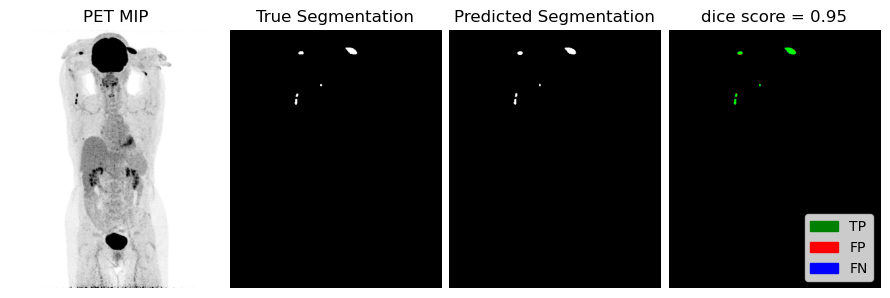

Dice Score: 0.6285604311008468


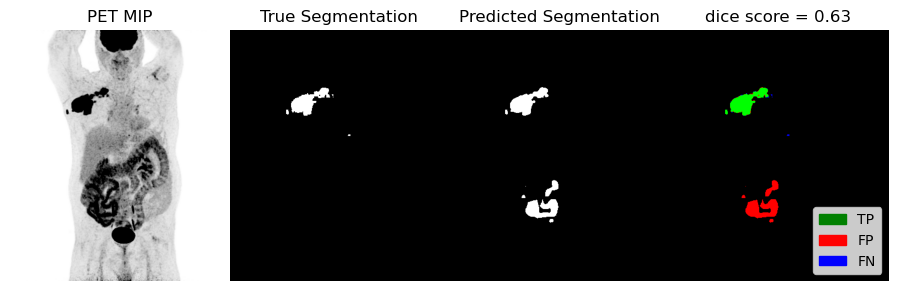

Dice Score: 0.8995215311004785


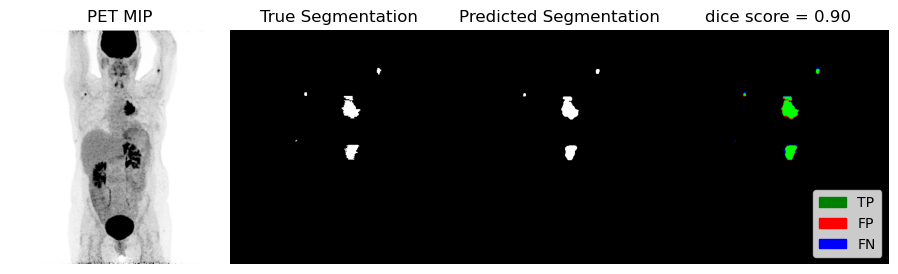

Dice Score: 0.940895114451657


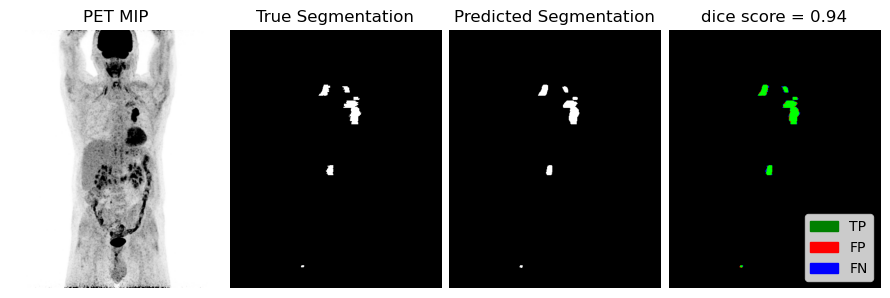

Dice Score: 0.8267477203647416


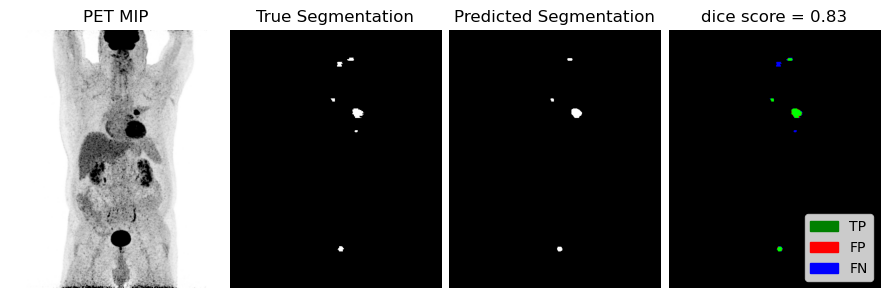

Dice Score: 0.8931506849315068


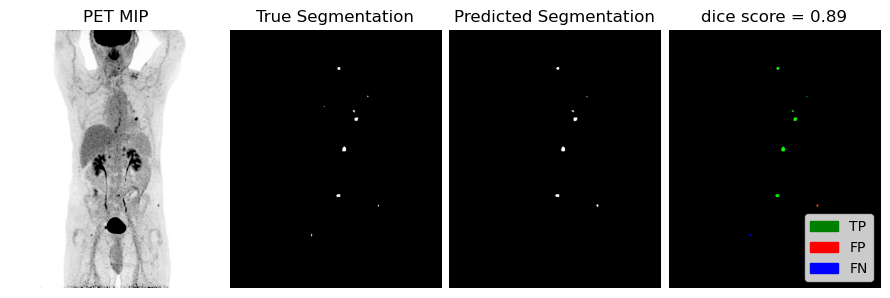

Dice Score: 0.9169262720664589


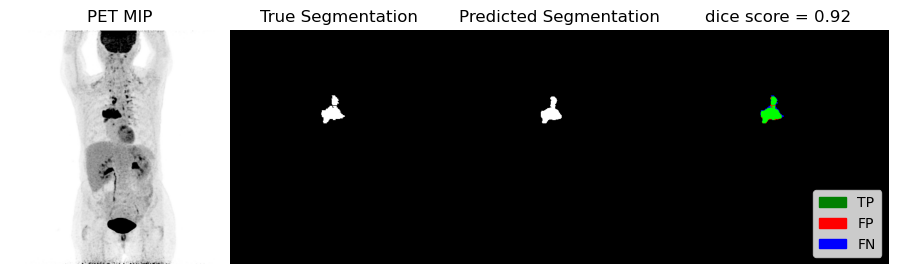

Dice Score: 0.9426176660219213


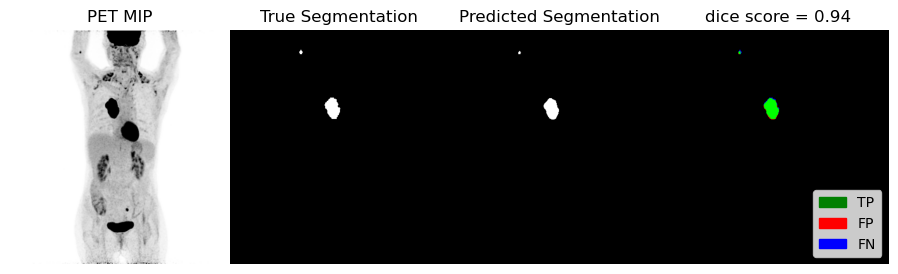

Dice Score: 0.8984737889847378


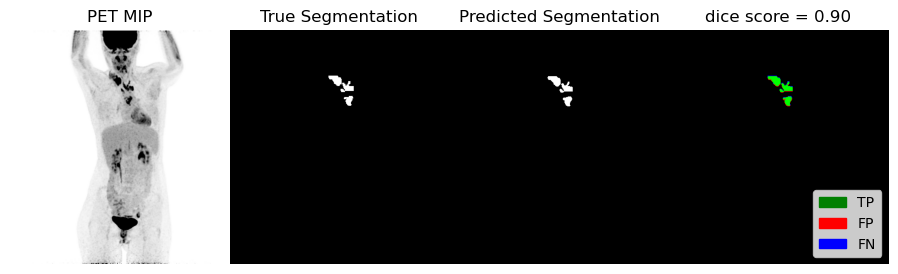

Dice Score: 0.8413821815154038


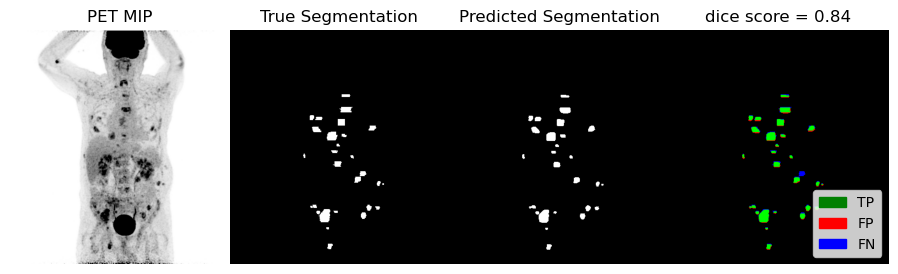

In [41]:
#average dice score

dice_scores = []
for i in range(0, 10):
    index_patient = '00' + str(i)
    seg_pred_path = f'data_validation/patients/labels/segmentation_{index_patient}.png'
    seg_true_path = f'data/patients/labels/segmentation_{index_patient}.png'

    seg_pred = cv2.imread(seg_pred_path)
    seg_true = cv2.imread(seg_true_path)

    dice_scores.append(dice_score(seg_true, seg_pred))

print('Average Dice Score: ', np.mean(dice_scores))

for i in range(0, 10):
    index_patient = '00' + str(i)
    img_f_path = f'data_validation/patients/imgs/patient_{index_patient}.png'
    seg_pred_path = f'data_validation/patients/labels/segmentation_{index_patient}.png'
    seg_true_path = f'data/patients/labels/segmentation_{index_patient}.png'

    # Read the images
    img_f = cv2.imread(img_f_path)
    seg_pred = cv2.imread(seg_pred_path)

    # Validate the segmentation
    validate_segmentation(img_f, seg_pred)

    seg_true = cv2.imread(seg_true_path)

    # Plot the prediction (assuming plot_prediction function exists and works correctly)
    plot_prediction(img_f, seg_true, seg_pred)

